In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import fitsio
import numpy             as np
import pylab             as pl
import matplotlib.pyplot as plt
import astropy.io.fits   as fits

In [3]:
sys.path.append('{}/DESI'.format(os.environ['HOME']))
sys.path.append('{}'.format(os.environ['HOME']))

In [4]:
import pubplot

from schechter     import schechter, named_schechter
from gama_limits   import gama_field
from delta8_limits import d8_limits, delta8_tier
from findfile      import findfile, fetch_fields
from lumfn         import multifield_lumfn
from astropy.table import Table

In [5]:
version = 'GAMA4'
survey  = 'gama'
field   = 'G12'
dryrun  = False

In [6]:
fields  = fetch_fields(survey)

In [7]:
# TODO: clean up root below in LF cells
root    = '{}/data/GAMA4/'.format(os.environ['HOME'])
fpath   =  findfile(ftype='ddp_n8', version=version, dryrun=dryrun, survey=survey)
fpath

'/cosma/home/durham/dc-wils7/data/GAMA4/gama_gold_ddp_n8.fits'

In [8]:
fpath   = findfile(ftype='randoms_bd_ddp_n8', field=field, version=version, dryrun=dryrun, survey=survey)
randoms = Table.read(fpath)

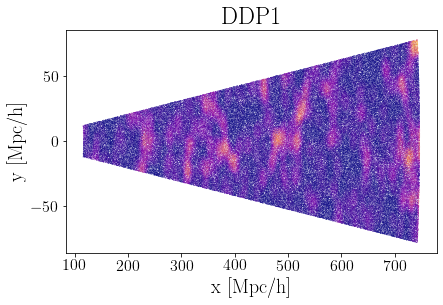

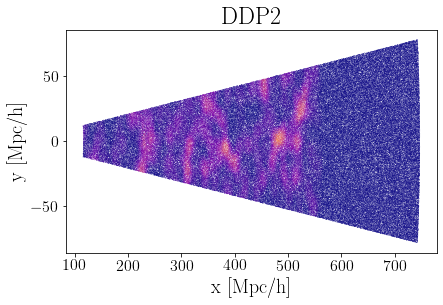

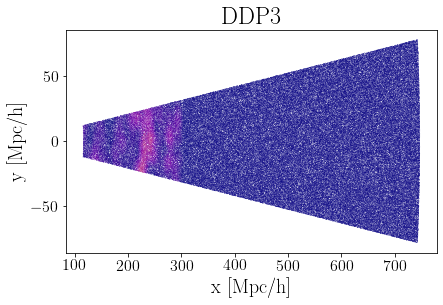

In [9]:
randoms_slice = randoms[np.abs(randoms['ROTCARTESIAN_Z']) < 5.]

for idx in np.arange(1, 4, 1):
    plt.scatter(randoms_slice['ROTCARTESIAN_X'],\
                randoms_slice['ROTCARTESIAN_Y'],\
                c=randoms_slice['DDP{}_DELTA8'.format(idx)],\
                marker='.',\
                lw=0.0,\
                s=1,\
                vmin=-1.,\
                vmax=10.,\
                cmap='plasma')

    pl.xlabel('x [Mpc/h]')
    pl.ylabel('y [Mpc/h]')
    
    plt.title('DDP{}'.format(idx))
    plt.show()

/tmp/ipykernel_6139/1454911877.py:17: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', marker='.', lw=0.0, c=colors[i], markersize=6)
/tmp/ipykernel_6139/1454911877.py:17: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', marker='.', lw=0.0, c=colors[i], markersize=6)
/tmp/ipykernel_6139/1454911877.py:17: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', marker='.', lw=0.0, c=colors[i], markersize=6)
/tmp/ipykernel_6139/1454911877.py:17: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', marker='.', lw=0.0, c=colors[i], markersize=6)
/tmp/ipykernel_6139/1454911877.py:17: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', marker='.', lw=0.0, c=colors[i], markersize=6)


Text(0.5, 1.0, 'G9/12/15')

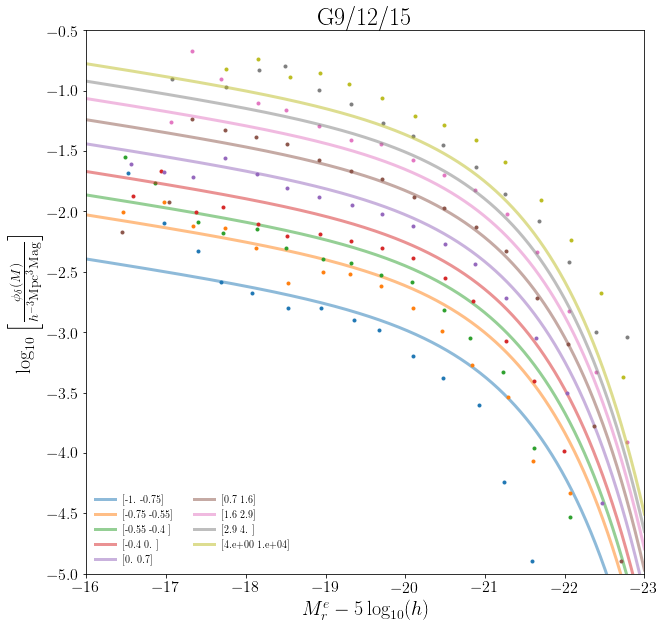

In [10]:
colors    = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax   = plt.subplots(1, 1, figsize=(10,10))

for i in np.arange(0, 9, 1):
    lfs   = [findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i)]
    lf    = multifield_lumfn(lfs, ext='LUMFN')

    ddp   = Table.read(findfile(ftype='ddp_n8_d0', survey=survey, field=field, version=version, utier=i))

    refs  = [findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i)]
    ref   = multifield_lumfn(refs, ext='REFERENCE')

    label = ddp.meta['D8{}LIMS'.format(i)]

    ax.plot(ref['MS'], np.log10(ref['REFSCHECHTER'.format(i)]), label=label, alpha=0.5, c=colors[i])
    ax.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', marker='.', lw=0.0, c=colors[i], markersize=6)
    
ax.set_xlabel(r'$M_r^e - 5 \log_{10}(h)$')
ax.set_ylabel(r'$\log_{10} \left[ \frac{\phi_\delta(M)}{h^{-3} {\rm Mpc}^{3} {\rm Mag}^{}} \right] $')

ax.set_xlim(-16., -23.0)
ax.set_ylim(-5, -0.5)

ax.legend(frameon=False, loc=3, ncol=2, fontsize=10)
ax.set_title('G9/12/15')

/tmp/ipykernel_6139/4157309795.py:15: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', lw=2.0, c=colors[i])
/tmp/ipykernel_6139/4157309795.py:15: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', lw=2.0, c=colors[i])
/tmp/ipykernel_6139/4157309795.py:15: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', lw=2.0, c=colors[i])
/tmp/ipykernel_6139/4157309795.py:15: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', lw=2.0, c=colors[i])
/tmp/ipykernel_6139/4157309795.py:15: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', lw=2.0, c=colors[i])
/tmp/ipykernel_6139/4157309795.py:15: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['P

Text(0.5, 1.0, 'G9/12/15')

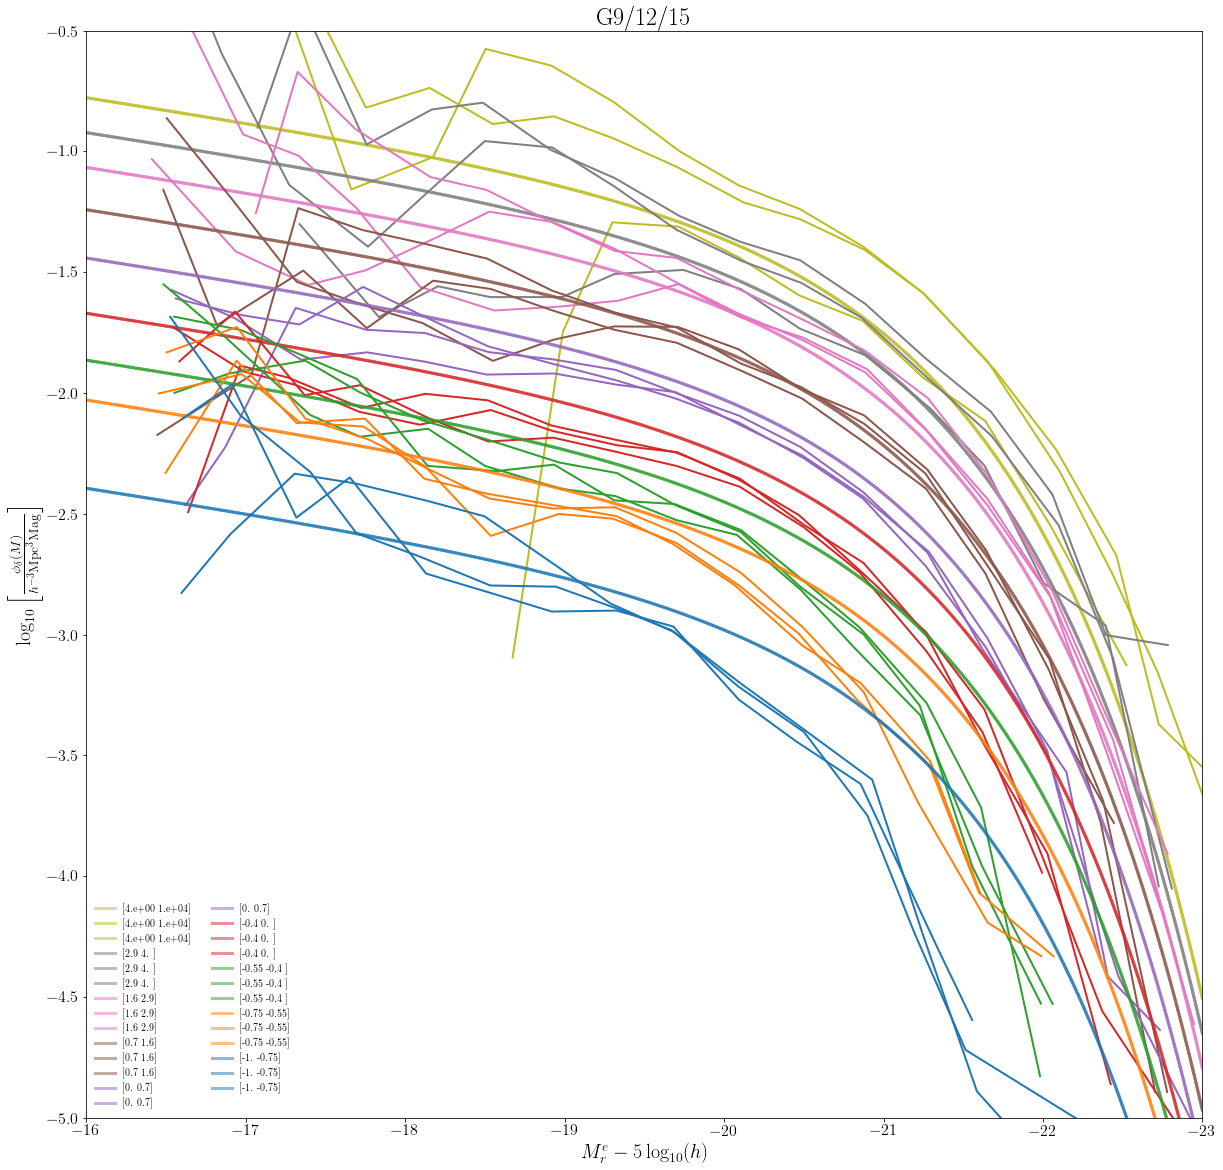

In [11]:
colors    = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax   = plt.subplots(1, 1, figsize=(20,20))

for i in np.arange(0, 9, 1)[::-1]:
    for field in fields:
        lf  = Table.read(findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i), 'LUMFN')
        ddp = Table.read(findfile(ftype='ddp_n8_d0', survey=survey, field=field, version=version, utier=i), 'DDP')

        ref = Table.read(findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i), 'REFERENCE')

        label = ddp.meta['D8{}LIMS'.format(i)]

        ax.plot(ref['MS'], np.log10(ref['REFSCHECHTER'.format(i)]), label=label, alpha=0.5, c=colors[i])
        ax.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', lw=2.0, c=colors[i])
    
ax.set_xlabel(r'$M_r^e - 5 \log_{10}(h)$')
ax.set_ylabel(r'$\log_{10} \left[ \frac{\phi_\delta(M)}{h^{-3} {\rm Mpc}^{3} {\rm Mag}^{}} \right] $')

ax.set_xlim(-16., -23.0)
ax.set_ylim(-5, -0.5)

ax.legend(frameon=False, loc=3, ncol=2, fontsize=10)
ax.set_title('G9/12/15')

/tmp/ipykernel_6139/1582905288.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1582905288.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1582905288.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1582905288.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1582905288.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1582905288.py:16: Runtime

Text(0.5, 1.0, 'G9/12/15')

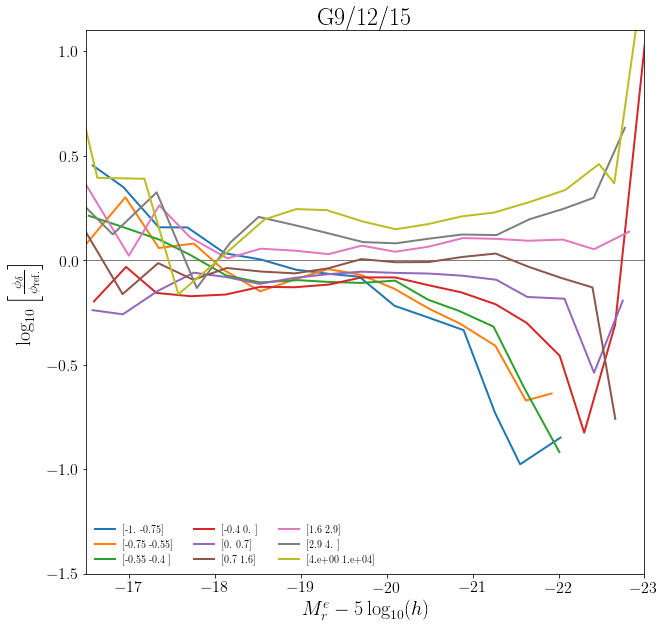

In [12]:
colors    = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax   = plt.subplots(1, 1, figsize=(10,10))

ax.axhline(0.0, lw=0.5, c='k')

for i in np.arange(0, 9, 1):
    lfs   = [findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i) for field in fields]
    lf    = multifield_lumfn(lfs, ext='LUMFN', weight=None)

    ddp   = Table.read(findfile(ftype='ddp_n8_d0', survey=survey, field=field, version=version, utier=i))
    ref   = Table.read(findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i), 'REFERENCE')

    label = ddp.meta['D8{}LIMS'.format(i)]

    ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
    
ax.set_xlabel(r'$M_r^e - 5 \log_{10}(h)$')
ax.set_ylabel(r'$\log_{10} \left[ \frac{\phi_\delta}{\phi_{\rm ref.}} \right] $')

ax.set_xlim(-16.5, -23.0)
ax.set_ylim(-1.5,    1.1)

ax.legend(frameon=False, loc=3, ncol=3, fontsize=10)
ax.set_title('G9/12/15')

/tmp/ipykernel_6139/1582905288.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1582905288.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1582905288.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1582905288.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1582905288.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1582905288.py:16: Runtime

Text(0.5, 1.0, 'G9/12/15')

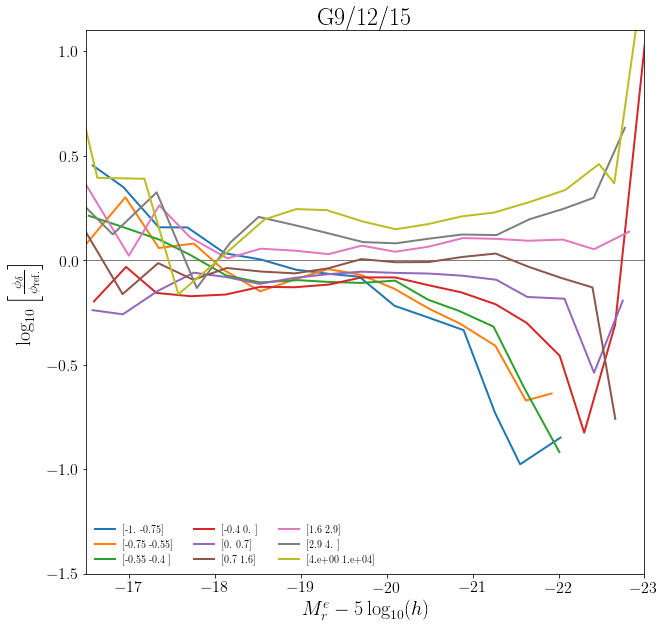

In [13]:
colors    = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax   = plt.subplots(1, 1, figsize=(10,10))

ax.axhline(0.0, lw=0.5, c='k')

for i in np.arange(0, 9, 1):
    lfs   = [findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i) for field in fields]
    lf    = multifield_lumfn(lfs, ext='LUMFN', weight=None)

    ddp   = Table.read(findfile(ftype='ddp_n8_d0', survey=survey, field=field, version=version, utier=i))
    ref   = Table.read(findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i), 'REFERENCE')

    label = ddp.meta['D8{}LIMS'.format(i)]

    ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
    
ax.set_xlabel(r'$M_r^e - 5 \log_{10}(h)$')
ax.set_ylabel(r'$\log_{10} \left[ \frac{\phi_\delta}{\phi_{\rm ref.}} \right] $')

ax.set_xlim(-16.5, -23.0)
ax.set_ylim(-1.5,    1.1)

ax.legend(frameon=False, loc=3, ncol=3, fontsize=10)
ax.set_title('G9/12/15')

/tmp/ipykernel_6139/1458464949.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1458464949.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1458464949.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1458464949.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1458464949.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
/tmp/ipykernel_6139/1458464949.py:16: Runtime

Text(0.5, 1.0, 'G9/12/15')

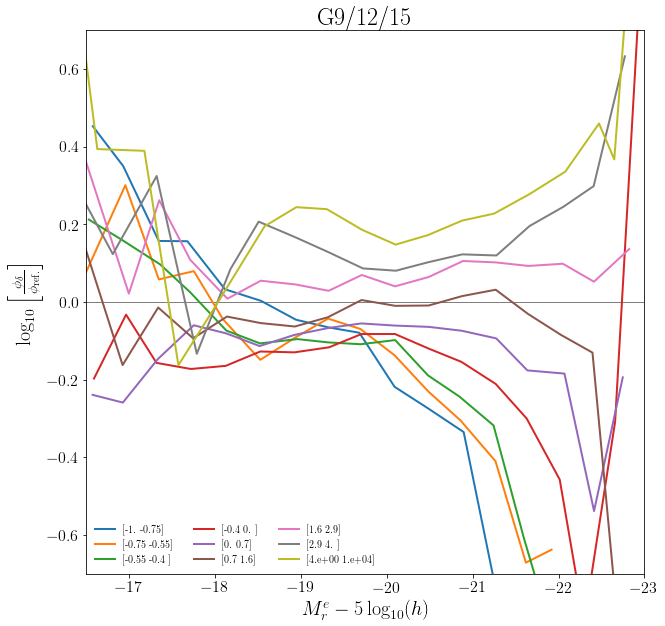

In [14]:
colors    = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax   = plt.subplots(1, 1, figsize=(10,10))

ax.axhline(0.0, lw=0.5, c='k')

for i in np.arange(0, 9, 1):
    lfs   = [findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i) for field in fields]
    lf    = multifield_lumfn(lfs, ext='LUMFN', weight=None)

    ddp   = Table.read(findfile(ftype='ddp_n8_d0', survey=survey, field=field, version=version, utier=i))
    ref   = Table.read(findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i), 'REFERENCE')

    label = ddp.meta['D8{}LIMS'.format(i)]

    ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=2.0, c=colors[i], markersize=4)
    
ax.set_xlabel(r'$M_r^e - 5 \log_{10}(h)$')
ax.set_ylabel(r'$\log_{10} \left[ \frac{\phi_\delta}{\phi_{\rm ref.}} \right] $')

ax.set_xlim(-16.5, -23.0)
ax.set_ylim(-0.7,    0.7)

ax.legend(frameon=False, loc=3, ncol=3, fontsize=10)
ax.set_title('G9/12/15')

# Done.